In [1]:
import chart_studio.plotly as py
import plotly.graph_objs as go

import MySQLdb
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
conn = MySQLdb.connect(host="localhost", user="root", passwd="", db="iot")
cursor = conn.cursor()
#cursor.execute('select time, source, destination, protocol, type, size from ip limit 250');
cursor.execute('SELECT time, sum(size) as size FROM ip WHERE time >="2018-03-08 12:38:00" AND time <"2018-03-08 12:48:00" group by time')

rows = cursor.fetchall()

cursor.execute('SELECT time, sum(size) as size FROM ip WHERE time >="2018-11-11 10:33:00" AND time <"2018-11-11 10:39:00" group by time')

rows2 = cursor.fetchall()

In [4]:
df = pd.DataFrame( [[ij for ij in i] for i in rows] )
df2 = pd.DataFrame( [[ij for ij in i] for i in rows2] )
df2.rename(columns={0: 'Time', 1: 'Size'}, inplace=True);
df.rename(columns={0: 'Time', 1: 'Size'}, inplace=True)
df['Size'] = pd.to_numeric(df['Size'])
df2['Size'] = pd.to_numeric(df2['Size'])
df.info()
df.head()
#df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 2 columns):
Time    555 non-null datetime64[ns]
Size    555 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.8 KB


,Time,Size
0,2018-03-08 12:38:00,126.0
1,2018-03-08 12:38:01,1276.0
2,2018-03-08 12:38:02,1374.0
3,2018-03-08 12:38:03,690.0
4,2018-03-08 12:38:05,460.0


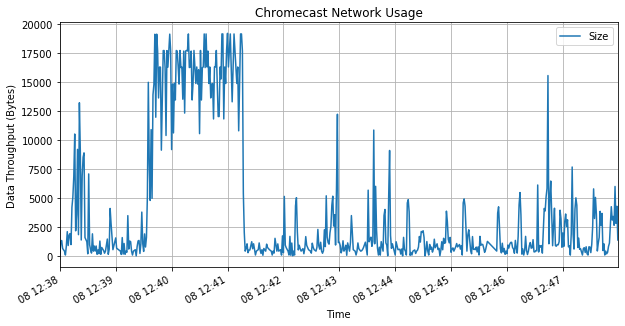

In [5]:
ax = df.plot(x='Time', y='Size', kind='line', grid=True, title='Chromecast Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
plt.show()

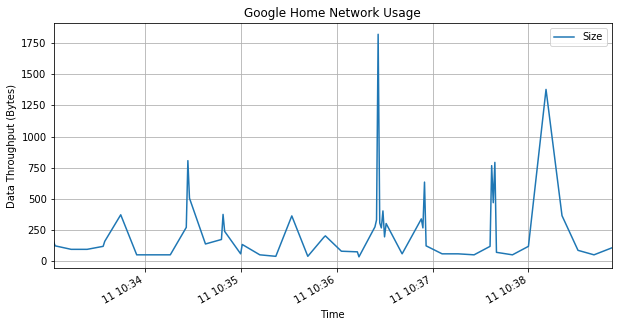

In [6]:
ax = df2.plot(x='Time', y='Size', kind='line', grid=True, title='Google Home Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
plt.show()

In [25]:
def ilp_constant_alg(input_df, constant_rate):
    output_df = pd.DataFrame(columns=['Time', 'Size'])
    stats = {'delayed' : 0, 'num_times_delayed' : 0, 'total_padding' : 0, 'num_times_padded' : 0}
    delayed = 0
    for index in range(len(input_df)):
        t = input_df['Time'].iloc[index]
        s = input_df['Size'].iloc[index]
        if (s < constant_rate):
            if (delayed > 0):
                stats['delayed'] += delayed
                stats['num_times_delayed'] += 1
                delayed -= constant_rate - s
                if (delayed < 0):
                    stats['total_padding'] += abs(delayed)
                    stats['num_times_padded'] += 1
                    delayed = 0
        elif (s > constant_rate):
            if (delayed > 0):
                stats['delayed'] += delayed
                stats['num_times_delayed'] += 1
            delayed += s - constant_rate
        else:
            if (delayed > 0):
                stats['delayed'] += delayed
                stats['num_times_delayed'] += 1
        output_df = output_df.append({'Time': t, 'Size': constant_rate}, ignore_index=True)
    return output_df, stats

In [26]:
ilp_const_df, ilp_const_stats = ilp_constant_alg(df, 12500)
ilp_const_df.head()

,Time,Size
0,2018-03-08 12:38:00,12500
1,2018-03-08 12:38:01,12500
2,2018-03-08 12:38:02,12500
3,2018-03-08 12:38:03,12500
4,2018-03-08 12:38:05,12500


In [27]:
for stat in ilp_const_stats:
    print("Stats : {} : {}".format(stat,ilp_const_stats[stat]))

Stats : delayed : 19672863.0
Stats : num_times_delayed : 128
Stats : total_padding : 25104.0
Stats : num_times_padded : 4


In [ ]:
#555 total entries
#total_padding / num_times_padded = network overhead